In [1]:
from astropy.io import fits
import numpy as np
from astropy.table import Table
import sys
sys.path.append('/Users/rociokiman/Documents/Gaia-Cupid/ActivityAgeRelation/banyan_sigma')
from banyan_sigma import banyan_sigma
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord  # High-level coordinates
import astropy.units as u
%config InlineBackend.figure_format = 'retina'

# Members from the literature: Checking compatibility

In [73]:
mg_mlsdss = fits.open('Catalogs/mactivity_movinggroups_gaia_mlsdss.fits')

In [85]:
mg_ref = Table.read('Catalogs/moving_groups_ref.csv',format='csv')
source_ref_table = Table.read('Catalogs/source_ref.csv',format='csv')

In [83]:
source_ref_table.colnames

['source_ref', 'source_num', 'cite', 'resolution']

In [92]:
mg_mlsdss[1].data['source_num']

array([ 1.,  1.,  1., ..., 14., 14., 14.])

In [94]:
len(mg_mlsdss[1].data['source_num'][mg_mlsdss[1].data['source_num']==5])

51

In [98]:
mg_mlsdss[1].data['source_id_2'][3]

-9223372036854775808

0
1
2
3
4
5
7
8
9
10
11
12
13
14
15
16
17
18
20
21
22
23
24
25


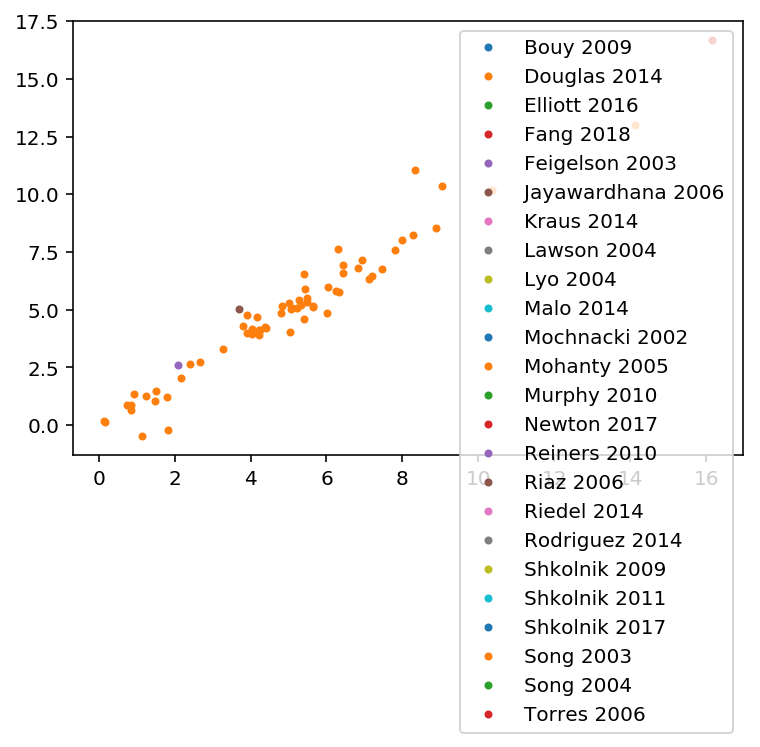

In [101]:
for i in range(len(source_ref['source_num'])):
    x = source_ref_table['source_num'][i]
    if((x in mg_mlsdss[1].data['source_num']) and (mg_mlsdss[1].data['source_id_2'][mg_mlsdss[1].data['source_num']==x][0]<0)):
        print(x)
        mask = mg_mlsdss[1].data['source_num'] == x
        plt.errorbar(mg_mlsdss[1].data['ewha_1'][mask],mg_mlsdss[1].data['EWHA_2'][mask],
                     label=source_ref_table['source_ref'][i],fmt='.')
plt.legend()

In [2]:
mg = fits.open('Catalogs/mactivity_movinggroups_gaia.fits')

In [4]:
ra = np.array([float(x) for x in mg[1].data['ra_x']])
ra_err = np.array([float(x) for x in mg[1].data['ra_error']])
dec = np.array([float(x) for x in mg[1].data['dec_x']])
pmra = np.array([float(x) for x in mg[1].data['pmra']])
pmra_error = np.array([float(x) for x in mg[1].data['pmra_error']])
pmdec = np.array([float(x) for x in mg[1].data['pmdec']])
pmdec_error = np.array([float(x) for x in mg[1].data['pmdec_error']])
parallax = np.array([float(x) for x in mg[1].data['parallax']])
parallax_error = np.array([float(x) for x in mg[1].data['parallax_error']])
rv = np.array([float(x) for x in mg[1].data['radial_velocity']])
rv_error = np.array([float(x) for x in mg[1].data['radial_velocity_error']])

In [5]:
len(ra)

5075

In [6]:
mask_nan = (~np.isnan(ra+dec+pmra+pmra_error+pmdec+pmdec_error+parallax+parallax_error) 
           * (parallax/parallax_error > 8))

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [7]:
group = np.array(mg[1].data['group_name'])[mask_nan]

In [8]:
len(ra[mask_nan])

4849

In [9]:
OUTPUT_STRUCTURE1 = banyan_sigma(ra=ra[mask_nan], dec=dec[mask_nan], pmra=pmra[mask_nan], pmdec=pmdec[mask_nan], 
                                epmra=pmra_error[mask_nan], epmdec=pmdec_error[mask_nan],
                                rv=rv[mask_nan], erv=rv_error[mask_nan], 
                                plx=parallax[mask_nan], eplx=parallax_error[mask_nan])

In [10]:
prob_ya = np.array(OUTPUT_STRUCTURE1['YA_PROB']).reshape(len(OUTPUT_STRUCTURE1['YA_PROB']),)
best_ya = np.array(OUTPUT_STRUCTURE1['BEST_YA']).reshape(len(OUTPUT_STRUCTURE1['BEST_YA']),)

In [11]:
highprob = prob_ya>0.8


In [12]:
len(best_ya[highprob])

1680

In [13]:
mg_table = Table.read('Catalogs/mactivity_movinggroups_gaia.fits')
mg_ref = Table.read('Catalogs/moving_groups_ref.csv')

In [14]:
highprob_mask = highprob.reshape(len(highprob),)

# Praesepe Members

In [15]:
source_id_praesepe = np.loadtxt('Catalogs/source_id_pra.txt')

In [16]:
bf_pra = np.array([True if x in source_id_praesepe else False for x in mg[1].data['source_id']])

In [17]:
def remove(string): 
    return string.replace(" ", "")

In [18]:
for i in range(len(mg_table['group_name'])):
    if(remove(mg_table['group_name'][i])=='PRA' and bf_pra[i]):
        mg_table['group_name'][i] = 'PRA'
        mg_table['group_num'][i] = mg_ref['group_num'][mg_ref['name']=='PRA'][0]
        mg_table['age'][i] = mg_ref['age'][mg_ref['name']=='PRA'][0]
        mg_table['age_error'][i] = mg_ref['age_error'][mg_ref['name']=='PRA'][0]

# Literature checked with Banyan + Praesepe

In [19]:
mask_all = np.logical_or(highprob_mask,bf_pra[mask_nan])

In [20]:
mg_table_mg = mg_table[mask_nan][mask_all]

In [21]:
mg_table_mg['ya_prob'] = prob_ya[mask_all]
mg_table_mg['best_ya'] = np.array([str(x) for x in best_ya[mask_all]])

In [22]:
len(mg_table_mg)

1705

# Correcting groups that don't agree

In [23]:
for i in range(len(mg_table_mg)):
    if(mg_table_mg['group_name'][i]!=mg_table_mg['best_ya'][i]):
        if(mg_table_mg['group_name'][i]!='PRA'):
            mask = mg_table_mg['best_ya'][i] == mg_ref['name']
            mg_table_mg['group_name'][i] = mg_ref['name'][mask][0]
            mg_table_mg['group_num'][i] = mg_ref['group_num'][mask][0]
            mg_table_mg['age'][i] = mg_ref['age'][mask][0]
            mg_table_mg['age_error'][i] = mg_ref['age_error'][mask][0]
        elif(mg_table_mg['group_name'][i]=='PRA'):
            mg_table_mg['best_ya'][i] = 'PRA'
            mg_table_mg['ya_prob'][i] = np.nan

# Members from MLSDSS-GaiaDR2

In [24]:
catalog = Table.read('../Gaia-Cupid/Catalogs/MLSDSS-GaiaDR2.fits')

In [25]:
mask_nan2 = (~np.isnan(catalog['RA']+catalog['DEC']+catalog['PMRA']+catalog['PMDEC']
                     +catalog['PMRA_ERR']+catalog['PMDEC_ERR']+catalog['RV']
                     +catalog['RV_ERR']+catalog['parallax']+catalog['parallax_error'])
            * (catalog['GOODMATCH'] == 1) 
            * (catalog['parallax']/catalog['parallax_error']>8))

/Users/rociokiman/anaconda3/lib/python3.7/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)


In [26]:
OUTPUT_STRUCTURE2 = banyan_sigma(ra=catalog['RA'][mask_nan2], dec=catalog['DEC'][mask_nan2], 
                                pmra=catalog['PMRA'][mask_nan2], pmdec=catalog['PMDEC'][mask_nan2], 
                                epmra=catalog['PMRA_ERR'][mask_nan2], 
                                epmdec=catalog['PMDEC_ERR'][mask_nan2],
                                rv=catalog['RV'][mask_nan2], erv=catalog['RV_ERR'][mask_nan2], 
                                plx=catalog['parallax'][mask_nan2], 
                                eplx=catalog['parallax_error'][mask_nan2])

In [27]:
prob_ya = np.array(OUTPUT_STRUCTURE2['YA_PROB']).reshape(len(OUTPUT_STRUCTURE2['YA_PROB']),)
best_ya = np.array(OUTPUT_STRUCTURE2['BEST_YA']).reshape(len(OUTPUT_STRUCTURE2['BEST_YA']),)

In [28]:
highprob = prob_ya>0.8

In [29]:
len(best_ya[highprob])

25

In [30]:
catalog_mg = catalog[mask_nan2][highprob]

In [31]:
catalog_mg['best_ya'] = best_ya[highprob]
catalog_mg['ya_prob'] = prob_ya[highprob]

In [32]:
age = []
age_error = []
group_name = []
group_num = []
for i in range(len(catalog_mg['best_ya'])):
    mask = catalog_mg['best_ya'][i] == mg_ref['name']
    age.append(mg_ref['age'][mask][0])
    age_error.append(mg_ref['age_error'][mask][0])
    group_name.append(mg_ref['name'][mask][0])
    group_num.append(mg_ref['group_num'][mask][0])

source_num = np.ones(len(catalog_mg['ya_prob']))*source_ref['source_num'][source_ref['source_ref']=='Kiman 2019'][0]
source_ref = np.array(['Kiman 2019' for x in range(len(catalog_mg['ya_prob']))])
    
age,age_error,group_name,group_num = np.array(age),np.array(age_error),np.array(group_name),np.array(group_num)

# Compiling full sample of M dwarfs from moving groups

In [46]:
fullsample = Table()

In [47]:
fullsample['ra'] = np.concatenate((mg_table_mg['ra'],catalog_mg['RA']))
fullsample['dec'] = np.concatenate((mg_table_mg['dec'],catalog_mg['DEC']))
fullsample['ra_gaia'] = np.concatenate((mg_table_mg['ra_x'],catalog_mg['RA']))
fullsample['dec_gaia'] = np.concatenate((mg_table_mg['dec_x'],catalog_mg['DEC']))
fullsample['spt'] = np.concatenate((mg_table_mg['spt'],catalog_mg['SPT']))
fullsample['phot_g_mean_mag'] = np.concatenate((mg_table_mg['phot_g_mean_mag'],catalog_mg['phot_g_mean_mag']))
fullsample['phot_rp_mean_mag'] = np.concatenate((mg_table_mg['phot_rp_mean_mag'],catalog_mg['phot_rp_mean_mag']))
fullsample['phot_bp_mean_mag'] = np.concatenate((mg_table_mg['phot_bp_mean_mag'],catalog_mg['phot_bp_mean_mag']))
fullsample['parallax'] = np.concatenate((mg_table_mg['parallax'],catalog_mg['parallax']))
fullsample['parallax_error'] = np.concatenate((mg_table_mg['parallax_error'],catalog_mg['parallax_error']))
fullsample['ewha'] = np.concatenate((mg_table_mg['ewha'],catalog_mg['EWHA']))
fullsample['ewha_error'] = np.concatenate((mg_table_mg['ewha_error'],catalog_mg['EWHA_ERR']))
fullsample['lhalbol'] = np.concatenate((mg_table_mg['lhalbol'],catalog_mg['LHALBOL']))
fullsample['lhalbol_error'] = np.concatenate((mg_table_mg['lhalbol_error'],catalog_mg['LHALBOL_ERR']))
fullsample['age'] = np.concatenate((mg_table_mg['age'],age))
fullsample['age_error'] = np.concatenate((mg_table_mg['age_error'],age_error))
fullsample['group_num'] = np.concatenate((mg_table_mg['group_num'],group_num))
fullsample['group_name'] = np.concatenate((mg_table_mg['group_name'],group_name))
fullsample['ya_prob'] = np.concatenate((mg_table_mg['ya_prob'],catalog_mg['ya_prob']))
fullsample['source_num'] = np.concatenate((mg_table_mg['source_num'],source_num))
fullsample['source_ref'] = np.concatenate((mg_table_mg['source_ref'],source_ref))

In [48]:
len(fullsample)

1730

# Identify repeated stars

In [49]:
mask = (fullsample['ewha']>0) * (fullsample['ewha']/fullsample['ewha_error']>3)
fullsample = fullsample[mask]

In [50]:
extra_id = np.arange(len(fullsample['ra']))
idx_sorted = np.argsort(fullsample['ra'])
ra_sorted = fullsample['ra'][idx_sorted]
dec_sorted = fullsample['dec'][idx_sorted]
extra_id_sorted = extra_id[idx_sorted]

In [51]:
same_star = np.zeros(len(ra_sorted))
dummy = 1
for i in range(len(ra_sorted)-1):
    c1 = SkyCoord(ra=ra_sorted[i]*u.deg, dec=dec_sorted[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted[i+1]*u.deg, dec=dec_sorted[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 2):
        same_star[i] = dummy
        same_star[i+1] = dummy
    else:
        dummy +=1

In [72]:
median_list = []
delta_list = []
max_min_list = []
rms_list = []
g_rp_list = []
for x in np.arange(1,int(max(same_star))+1):
    mask = same_star == x
    if(any(mask)):
        same_star_id = extra_id_sorted[mask]
        if(all(np.isclose(x,fullsample[same_star_id]['ra_gaia'][0]) for x in fullsample[same_star_id]['ra_gaia']) and
           all(np.isclose(x,fullsample[same_star_id]['dec_gaia'][0]) for x in fullsample[same_star_id]['dec_gaia'])):
            N = len(fullsample['ewha'][same_star_id])
            median = np.median(fullsample['ewha'][same_star_id])
            median_list.append(median)
            delta = max(fullsample['ewha'][same_star_id])-min(fullsample['ewha'][same_star_id])
            delta_list.append(delta)
            max_min = max(fullsample['ewha'][same_star_id])/min(fullsample['ewha'][same_star_id])
            max_min_list.append(max_min)
            mean = np.mean(fullsample['ewha'][same_star_id])
            rms = np.sqrt((1/N)*sum((fullsample['ewha'][same_star_id]-median)**2))
            rms_list.append(rms/median)
            g_rp_list.append(fullsample['phot_g_mean_mag'][same_star_id][0]-fullsample['phot_rp_mean_mag'][same_star_id][0])
            print(fullsample['ewha','source_num','ra','dec'][same_star_id])
        else:
            print(fullsample[same_star_id]['ra_gaia','dec_gaia'])

median_list,delta_list,max_min_list,rms_list = np.array(median_list),np.array(delta_list),np.array(max_min_list),np.array(rms_list) 
g_rp_list = np.array(g_rp_list)


       ewha       source_num         ra               dec       
----------------- ---------- ----------------- -----------------
3.559000015258789       14.0 4.236679166666666 20.06532583333333
              2.5       11.0         4.2367512        20.0653362
       ewha       source_num         ra               dec        
----------------- ---------- ----------------- ------------------
              6.0       16.0 4.347499999999999 -66.75333333333333
              6.0       10.0 4.348041666666665 -66.75344444444444
4.800000190734863       17.0 4.348041666666666 -66.75347222222221
              6.0       22.0         4.3480867        -66.7534256
ewha source_num     ra        dec    
---- ---------- --------- -----------
0.68        7.0 6.3110417 -61.5134167
 1.0        5.0 6.3110919 -61.5134034
       ewha       source_num         ra                dec        
----------------- ---------- ------------------ ------------------
              7.8       16.0  6.959291666666665 -32.551666

 ewha source_num     ra         dec    
----- ---------- ---------- -----------
10.01        7.0 52.3187083 -37.0472778
 8.63       18.0 52.3190417 -37.0472778
       ewha       source_num         ra                dec        
----------------- ---------- ------------------ ------------------
             1.17        7.0         52.9818333        -43.9870833
1.899999976158142       10.0 52.981833333333334 -43.98708333333333
       ewha       source_num    ra          dec        
----------------- ---------- ------- ------------------
              5.0       16.0 55.6325 12.272916666666667
5.659999847412109       20.0 55.6325 12.272944444444443
       ewha        source_num         ra                dec        
------------------ ---------- ------------------ ------------------
3.0999999046325684       10.0 56.419083333333326  -75.1533611111111
               3.1       16.0 56.419083333333326 -75.15336111111111
       ewha       source_num         ra                 dec        
--------

       ewha       source_num         ra                 dec        
----------------- ---------- ------------------ -------------------
              8.3       16.0 156.35679166666665 -49.310805555555554
8.300000190734863       10.0 156.35679166666668 -49.310805555555554
ewha source_num         ra                dec        
---- ---------- ----------------- -------------------
 5.8        5.0       160.6254255          -33.671174
 6.5       16.0 160.6254583333333 -33.671166666666664
 6.5       10.0 160.6254583333333 -33.671166666666664
 ewha source_num         ra                dec        
----- ---------- ------------------ ------------------
172.5        5.0        165.4662726        -34.7047309
 13.8       16.0 165.46629166666665 -34.70472222222222
 ewha source_num         ra                dec        
----- ---------- ------------------ ------------------
 12.7       16.0 167.61616666666663 -37.53111111111111
40.89       21.0        167.6166667        -37.5308333
       ewha       

ewha source_num         ra                 dec        
---- ---------- ------------------ -------------------
 6.3       16.0 307.18170833333323 -11.475194444444444
 5.0       17.0 307.18179166666664 -11.475222222222222
       ewha        source_num         ra                 dec        
------------------ ---------- ------------------ -------------------
              11.4       16.0 308.40662499999996 -25.947805555555554
12.600000381469727       17.0 308.40662499999996  -25.94780555555555
11.399999618530273       10.0 308.40662499999996 -25.947805555555554
              11.4       22.0        308.4066514         -25.9478094
       ewha       source_num         ra                 dec        
----------------- ---------- ------------------ -------------------
              7.2       16.0 310.92141666666663 -24.564833333333333
5.239999771118164       20.0  310.9214583333333 -24.564861111111103
8.029999732971191       20.0  310.9214583333333 -24.564861111111103
ewha source_num         ra

In [53]:
lee2010 = Table.read('Catalogs/Lee2010.csv')

In [54]:
lee2010.colnames

['Source',
 'Spectral Type',
 'Published EW',
 'Ref',
 'MeanEW',
 'MeanEW_err',
 'MinEW',
 'MinEW_err',
 'MaxEW',
 'MaxEW_err',
 'DeltaEW',
 'DeltaEW_err',
 'rmsEW',
 'rmsEW_err',
 'Mean logL_Halpha/L_bol',
 'Max logL_Halpha/L_bol']

In [55]:
spt_lee2010 = np.array([float(x) for x in lee2010['Spectral Type']])

In [56]:
g_rp_lee2010 = -0.0036*np.array(lee2010['Spectral Type'])**2 + 0.11*np.array(lee2010['Spectral Type']) + 0.89

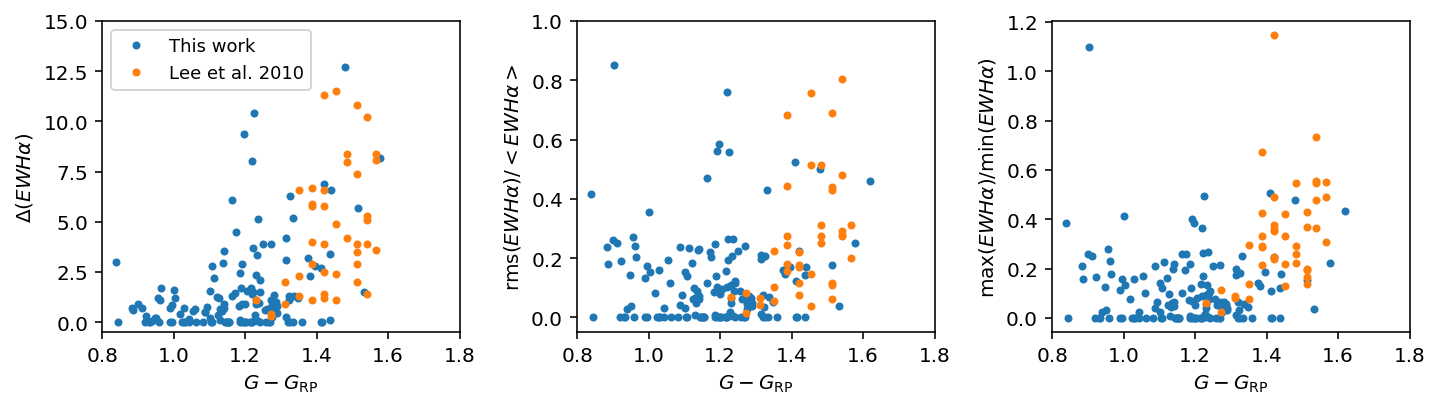

In [71]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,sharex=True, figsize=(10,3))
ax1.plot(g_rp_list,delta_list,'.', label='This work')
ax1.plot(g_rp_lee2010,lee2010['DeltaEW'],'.',label='Lee et al. 2010')
ax1.set_ylim(-0.5,15)
ax1.set_xlim(0.8,1.8)
#ax1.set_yscale('log')
ax1.set_xlabel(r'$G-G_{\rm RP}$')
ax1.set_ylabel(r'$\Delta (EWH\alpha)$')
ax1.legend(fontsize=9)

ax2.plot(g_rp_list,rms_list,'.')
ax2.plot(g_rp_lee2010,lee2010['rmsEW']/lee2010['MeanEW'],'.')
ax2.set_ylim(-0.05,1)
#ax2.set_xlim(-1.5,18)
ax2.set_xlabel(r'$G-G_{\rm RP}$')
ax2.set_ylabel(r'${\rm rms} (EWH\alpha)/<EWH\alpha>$')

ax3.plot(g_rp_list,np.log10(max_min_list),'.')
ax3.plot(g_rp_lee2010,np.log10(lee2010['MaxEW']/lee2010['MinEW']),'.')
#ax3.set_ylim(0.8,5)
#ax3.set_xlim(-1.5,18)
ax3.set_xlabel(r'$G-G_{\rm RP}$')
ax3.set_ylabel(r'$\max (EWH\alpha)/\min (EWH\alpha)$')


plt.tight_layout()
plt.show()

In [72]:
mean = []
std = []
remove_idx = np.zeros(len(fullsample))
for x in np.arange(1,int(max(same_star))+1):
    mask = same_star == x
    if(any(mask)):
        same_star_id = extra_id_sorted[mask]
        if(all(np.isclose(x,fullsample[same_star_id]['ra_gaia'][0]) for x in fullsample[same_star_id]['ra_gaia']) and
           all(np.isclose(x,fullsample[same_star_id]['dec_gaia'][0]) for x in fullsample[same_star_id]['dec_gaia'])):
            N = len(fullsample['ewha'][same_star_id])
            mean = (sum(fullsample['ewha'][same_star_id]/fullsample['ewha_error'][same_star_id])/
                    sum(1./fullsample['ewha_error'][same_star_id]))
            std = ((N)*sum(1./fullsample['ewha_error'][same_star_id])**(-2))**1/2
            for i in same_star_id:
                fullsample['ewha'][i] = mean
                fullsample['ewha_error'][i] = std
            for i in same_star_id[1:]:
                remove_idx[i] = 1
        else:
            print(fullsample[same_star_id]['ra_gaia','dec_gaia'])

In [73]:
mask_remove_same_stars = remove_idx == 0

In [74]:
fullsample_singles = fullsample[mask_remove_same_stars]

In [75]:
idx_sorted_test = np.argsort(fullsample_singles['ra'])
ra_sorted_test = fullsample_singles['ra'][idx_sorted_test]
dec_sorted_test = fullsample_singles['dec'][idx_sorted_test]

In [76]:
for i in range(len(ra_sorted_test)-1):
    c1 = SkyCoord(ra=ra_sorted_test[i]*u.deg, dec=dec_sorted_test[i]*u.deg)
    c2 = SkyCoord(ra=ra_sorted_test[i+1]*u.deg, dec=dec_sorted_test[i+1]*u.deg)
    separation = c1.separation(c2).arcsec
    if(separation < 2):
        print(c1,c2)

In [77]:
len(fullsample_singles)

1395

# Save final sample

In [35]:
fullsample.write('Catalogs/mactivity_movinggroups_confirmed.fits',format='fits',
                  overwrite=True)